# Introduction

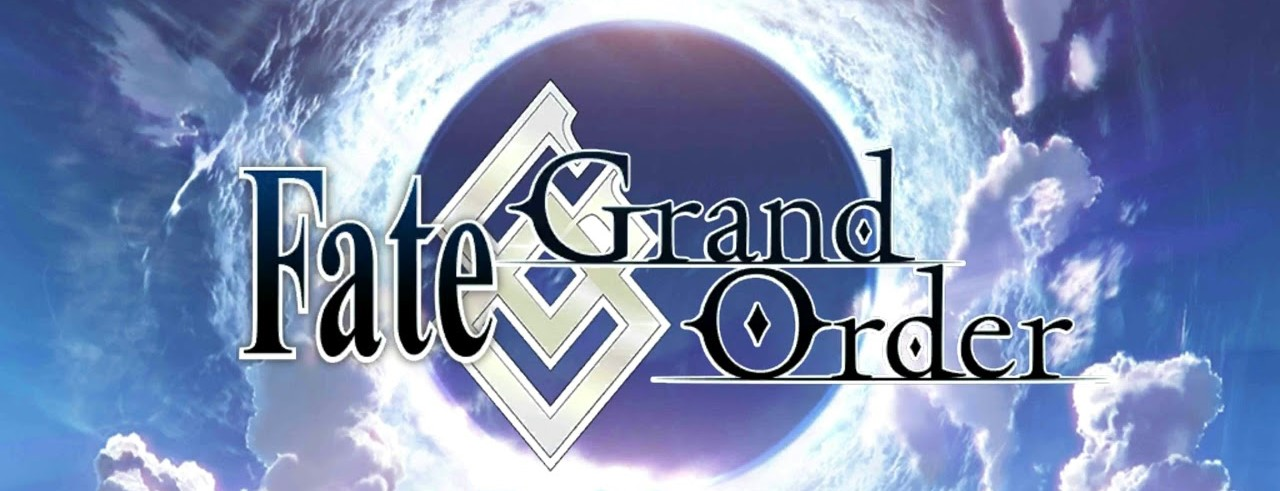

## What is Fate/Grand Order

<a href="https://en.wikipedia.org/wiki/Fate/Grand_Order">Fate/Grand Order</a>, or FGO, is a free-to-play turn-based role-playing mobile game. The game was originally released in Japan in 2015 and has released several other servers (North America, China, Korea) in subsequent years.
The game earns revenue through its gacha system, where users pay in-game currency, saint quartz, to roll for units in a lottery-grab-bag system. Units have varying statistics such as HP, attack, rarity, availability, and more. As one might expect, units with higher stats are harder to obtain. 

## Why Care

The gacha mechanic is an extremely lucrative game mechanic. In July 2021, the game grossed \$5.4 billion worldwide, making it the seventh highest-grossing mobile game of all time. Players are not required to pay out of pocket for units, nor are "better" level units necessary to advance in the game. However, these better units are highly desirable for various reasons such as making the game easier to clear, eye-catching visuals, good voice actors, and more. Players who pay money, commonly referred to as whales, can spend exorbitant amounts of money for these characters such as <a href="https://www.youtube.com/watch?v=z-fxfuWhff0"> the man who spent $70,000</a>.

## Goal

While FGO became the seventh highest-grossing mobile game in 2021, the game's revenue has been steadily decreasing within recent years. The biggest indicator was the 81% drop from July 2019 to July 2020. 
In this project, I will quantify the decrease in revenue for Fate/Grand Order and examine some possible explanations for it. 

I chose to analyze the revenue for the Japanese server because it is the original server, and the North American server's revenue is quite small in comparison. Furthermore, because the North American server runs 2 years behind the Japanese server, many players plan which banners they want to save or spend on.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import itertools
import time
import json
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from scipy.stats.stats import pearsonr
from operator import methodcaller
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import math

# Webscraping and Data Cleaning

## Game Revenue by Month

The first dataset we'll scrape is the monthly revenue and average ranking starting from 2018. All revenue is in terms of billion yen.

In [2]:
# Create an URL object
url = 'https://game-i.daa.jp/?%E3%82%A2%E3%83%97%E3%83%AA/Fate/Grand+Order'
# Create object page
page = requests.get(url)
page # <Response [200]> We can scrape from the website.

<Response [200]>

In [3]:
table = pd.read_html("https://game-i.daa.jp/?%E3%82%A2%E3%83%97%E3%83%AA/Fate/Grand+Order")

In [4]:
info_table = []
for i in table:
    if '年月' in i.columns:
        i.columns = ["Month", "Revenue", "Average iOS Ranking"]
        info_table.append(i)

In [5]:
info_table[1]

,Month,Revenue,Average iOS Ranking
0,2021/12,39.59億G,9.9位
1,2021/11,39.49億G,7.8位
2,2021/10,25.59億G,14.1位
3,2021/09,67.10億G,6.6位
4,2021/08,90.29億G,4.8位
5,2021/07,17.82億G,22.1位
6,2021/06,32.82億G,13.3位
7,2021/05,8.93億G,22.3位
8,2021/04,9.75億G,31位
9,2021/03,17.43億G,17.9位


In [6]:
months = []
revenues = []
avg_ranking = []
for table in info_table:
    months.append(table['Month'][:12])
    revenues.append(table['Revenue'][:12])
    avg_ranking.append(table['Average iOS Ranking'][:12])
months = list(itertools.chain(*months))
revenues = list(itertools.chain(*revenues))
avg_ranking = list(itertools.chain(*avg_ranking))

In [7]:
monthly_revenue_df = pd.DataFrame(list(zip(months, revenues, avg_ranking)),
               columns =['Month', 'Revenue', 'Average iOS Ranking'])
monthly_revenue_df['Average iOS Ranking'] = monthly_revenue_df['Average iOS Ranking'].apply(str)
monthly_revenue_df.head(10)

,Month,Revenue,Average iOS Ranking
0,2022/12,未,nan
1,2022/11,未,nan
2,2022/10,未,nan
3,2022/09,未,nan
4,2022/08,未,nan
5,2022/07,33.87億G,9.8位
6,2022/06,39.55億G,19.9位
7,2022/05,20.82億G,33.3位
8,2022/04,35.97億G,17.1位
9,2022/03,35.58億G,17.2位


In [8]:
def month_datetime(month):
    month = month + "/01"
    date = pd.to_datetime(month)
    return(date)
def revenue_fix(word):
    if word == '未':
        return 0
    number = 0
    if '億' in word:
        number = float(re.sub("[^0-9.]", "", word))*100000000
    if '万' in word:
        number = float(re.sub("[^0-9.]", "", word))*10000
    return(number/1000000000) #divide by 1 billion

def ranking_fix(word):
    if word == 'nan':
        return None
    else:
        return re.sub("位", "", word)

In [9]:
monthly_revenue_df['Month'] = list(map(month_datetime, monthly_revenue_df['Month']))
monthly_revenue_df['Revenue'] = pd.to_numeric(list(map(revenue_fix, monthly_revenue_df['Revenue'])))
monthly_revenue_df['Average iOS Ranking'] = pd.to_numeric(list(map(ranking_fix, monthly_revenue_df['Average iOS Ranking'])))
monthly_revenue_df['Month'] = monthly_revenue_df['Month'].dt.to_period('M')
monthly_revenue_df.head(10)

,Month,Revenue,Average iOS Ranking
0,2022-12,0.000,NaN
1,2022-11,0.000,NaN
2,2022-10,0.000,NaN
3,2022-09,0.000,NaN
4,2022-08,0.000,NaN
5,2022-07,3.387,9.8
6,2022-06,3.955,19.9
7,2022-05,2.082,33.3
8,2022-04,3.597,17.1
9,2022-03,3.558,17.2


## Banner Revenue 

This dataset includes the revenue generated for each banner in Fate/Grand Order. 
Banners are a huge part of the gacha mechanic. They appear for a short period of time and feature certain units. These units will be on "rate-up", meaning they are easier to obtain. Some units are limited and only appear on specific banners.
Though I do not know how the website determined the banner generated revenue, I assume the banner generated revenue based on the accumulation of revenue during the days the banner was available.

In [10]:
base_url = "https://game-i.daa.jp/?%E3%82%AC%E3%83%81%E3%83%A3%E5%88%86%E6%9E%90%2FFate%2FGrand%20Order&yyyy="
years = list(range(2018, 2023))

In [11]:
def get_Banners(year:int):
    url = base_url + str(year)
    gacha_tabs = pd.read_html(url)
    return gacha_tabs

In [12]:
banner_list = []
for year in years:
    banner_list.append(get_Banners(year))
x = list(itertools.chain(*banner_list))
y = []
for i in x:
    if len(i) == 3:
        y.append(i)

In [13]:
banner_dates = []
banner_revenue = []
banner_ranking = []

for table in y:
    banner_dates.append(table[1][0])
    banner_revenue.append(table[1][1])
    banner_ranking.append(table[1][2])

In [14]:
dates = pd.Series(banner_dates)
dates = dates.str.split('～')

start_dates = []
end_dates = []
for date in dates:
    start_dates.append(re.sub("日", "", re.sub("[年月]", "-", date[0])))
    end_dates.append(re.sub("日", "", re.sub("[年月]", "-", date[1])))

In [15]:
ranking = pd.Series(banner_ranking)
ranking = ranking.str.split('位')

index = 0
while index < len(banner_revenue):
    banner_ranking[index] = ranking[index][0]
    index = index+1

In [16]:
revenue_df = pd.DataFrame(list(zip(start_dates, end_dates, list(map(revenue_fix, banner_revenue)), banner_ranking)),
               columns =['Banner Start Date', 'Banner End Date', 'Revenue', 'Ranking'])
revenue_df['Banner Start Date'] = pd.to_datetime(revenue_df['Banner Start Date'])
revenue_df['Banner End Date'] = pd.to_datetime(revenue_df['Banner End Date'])
revenue_df['Revenue'] = pd.to_numeric(revenue_df['Revenue'])
revenue_df['Ranking'] = pd.to_numeric(revenue_df['Ranking'])
revenue_df.head()

,Banner Start Date,Banner End Date,Revenue,Ranking
0,2018-12-21,2018-12-31,2.036,66
1,2018-12-12,2018-12-25,3.265,13
2,2018-12-04,2018-12-18,3.096,17
3,2018-11-27,2018-12-11,3.053,19
4,2018-11-14,2018-11-28,2.358,49


## Banner Dates and Servants

This dataset includes every banner, the servants in each banner, the Japanese start/end date, and the North American start/end date.

In [17]:
# Create an URL object
url = 'https://gamepress.gg/grandorder/summon-banner-list'
# Create object page
page = requests.get(url)
page # <Response [200]> We can scrape from the website.

<Response [200]>

In [18]:
# Dynamically install a Chrome web driver and instantiate it
driver = webdriver.Chrome()
# Make the driver wait 7 seconds for the page to load
driver.implicitly_wait(10)
driver.get("https://gamepress.gg/grandorder/summon-banner-list")
driver.refresh()
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "banner-table")))
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "banner-list")))
table_data = driver.find_element(By.XPATH,"/html/body/div[2]/main/section/div[1]/div[2]/div[2]/article/div[2]/div[4]/span/div/div/div/table/tbody")

rows = table_data.find_elements(By.TAG_NAME, "tr")

In [19]:
num_banner = []
banner_name = []
jp_period = []
na_period= []
servants_single = []
servants_shared = []

for row in rows:
    col = row.find_elements(By.TAG_NAME, "td")
    num_banner.append(col[0].text)
    banner_name.append(col[1].text)
    jp_period.append(col[2].text)
    na_period.append(col[3].text)
    servants_single.append(col[4].text)
    servants_shared.append(col[5].text)

driver.close()

In [20]:
banner_df = pd.DataFrame(list(zip(num_banner, banner_name, jp_period, na_period, servants_single, servants_shared)),
               columns =['Num', 'Name', 'JP Period', 'NA Period', 'Servants Single', 'Servants Shared'])
banner_df['Num'] = banner_df['Num'].astype(int)
banner_df = banner_df.sort_values(['Num'])
banner_df.head()

,Num,Name,JP Period,NA Period,Servants Single,Servants Shared
356,1,"66,666 Likes Pickup Summon",,2017-07-06\n2017-07-20,Gilgamesh,"Atalante, Lancelot, Cu Chulainn (Prototype), M..."
355,2,Nero Fest,,2017-07-25\n2017-08-03,"Altera, Nero Claudius","Gaius Julius Caesar, Romulus"
354,3,Orleans Pickup Summon,,2017-08-08\n2017-08-17,Jeanne d'Arc,"Siegfried, Chevalier d'Eon, Gilles de Rais, Ki..."
353,4,Moon Festival,,2017-08-17\n2017-08-31,Orion,"Stheno, Marie Antoinette, Ushiwakamaru, Jing Ke"
352,5,Fuyuki Pickup Summon,,2017-09-14\n2017-09-21,Altria Pendragon,"EMIYA, Heracles, Cu Chulainn, Medusa, Medea"


Some data cleaning here.

In [21]:
def get_start_end_years(years):
    s = pd.Series(years)
    s = s.str.split('\n')
    index = 0
    while index < len(s):
        if len(s[index]) == 1:
            s[index] = [None, None]
        index += 1
        
    start_date = s.str[0]
    end_date = s.str[1]
    return [start_date, end_date]

In [22]:
jp_years = get_start_end_years(banner_df['JP Period'])
na_years = get_start_end_years(banner_df['NA Period'])

banner_df = banner_df.drop(columns=['JP Period', 'NA Period'])

banner_df['JP Start Date'] = pd.to_datetime(jp_years[0])
banner_df['JP End Date'] = pd.to_datetime(jp_years[1])
banner_df['NA Start Date'] = pd.to_datetime(na_years[0])
banner_df['NA End Date'] = pd.to_datetime(na_years[1])

banner_df.head()

,Num,Name,Servants Single,Servants Shared,JP Start Date,JP End Date,NA Start Date,NA End Date
356,1,"66,666 Likes Pickup Summon",Gilgamesh,"Atalante, Lancelot, Cu Chulainn (Prototype), M...",NaT,NaT,2017-07-06,2017-07-20
355,2,Nero Fest,"Altera, Nero Claudius","Gaius Julius Caesar, Romulus",NaT,NaT,2017-07-25,2017-08-03
354,3,Orleans Pickup Summon,Jeanne d'Arc,"Siegfried, Chevalier d'Eon, Gilles de Rais, Ki...",NaT,NaT,2017-08-08,2017-08-17
353,4,Moon Festival,Orion,"Stheno, Marie Antoinette, Ushiwakamaru, Jing Ke",NaT,NaT,2017-08-17,2017-08-31
352,5,Fuyuki Pickup Summon,Altria Pendragon,"EMIYA, Heracles, Cu Chulainn, Medusa, Medea",NaT,NaT,2017-09-14,2017-09-21


In [23]:
df3 = banner_df.merge(revenue_df, how='left', left_on='JP Start Date', right_on='Banner Start Date')
df3.drop(['Banner Start Date', 'Banner End Date'], axis=1, inplace=True)
#df3 = df3.dropna(subset="Ranking")
#df3 = df3[list(df3['Servants Single'] != "") or list(df3['Servants Shared'] != '')].drop_duplicates()
df3.head()

,Num,Name,Servants Single,Servants Shared,JP Start Date,JP End Date,NA Start Date,NA End Date,Revenue,Ranking
0,1,"66,666 Likes Pickup Summon",Gilgamesh,"Atalante, Lancelot, Cu Chulainn (Prototype), M...",NaT,NaT,2017-07-06,2017-07-20,NaN,NaN
1,2,Nero Fest,"Altera, Nero Claudius","Gaius Julius Caesar, Romulus",NaT,NaT,2017-07-25,2017-08-03,NaN,NaN
2,3,Orleans Pickup Summon,Jeanne d'Arc,"Siegfried, Chevalier d'Eon, Gilles de Rais, Ki...",NaT,NaT,2017-08-08,2017-08-17,NaN,NaN
3,4,Moon Festival,Orion,"Stheno, Marie Antoinette, Ushiwakamaru, Jing Ke",NaT,NaT,2017-08-17,2017-08-31,NaN,NaN
4,5,Fuyuki Pickup Summon,Altria Pendragon,"EMIYA, Heracles, Cu Chulainn, Medusa, Medea",NaT,NaT,2017-09-14,2017-09-21,NaN,NaN


## FGO Servant Stats

This dataset comes from a different project where I looked at the gender distribution in the game.

In [24]:
fgo_stats = pd.read_csv("fgo_stats.csv", encoding="raw_unicode_escape")
#The columns we want: Servant_Name, Availability, Class, Rarity, ID, ATKs, HPs, Gender, Summer Servant
fgo_stats.tail()

,Servant_Name,Availability,Class,Rarity,Num_Alias,ID,Cost,ATK,Max_ATK,HP,...,NP_Charge_DEF,Death_Rate,Alignments1,Alignments2,Gender,Quick_Hits,Arts_Hits,Buster_Hits,Extra_Hits,is_Summer_Servant
357,Tiamat,Unplayable Servants,Beast,5,1,149,16,2101.0,13596.0,2745.0,...,0.0,11.0,Chaotic,Evil,Female,1.0,1.0,1.0,1.0,False
358,Goetia,Unplayable Servants,Beast,5,3,151,16,2268.0,24721.0,11400.0,...,0.0,0.0,Chaotic,Evil,Unknown,5.0,5.0,5.0,1.0,False
359,Beast III/R,Unplayable Servants,Beast,5,5,168,16,13728.0,18720.0,15027.0,...,3.0,0.0,Chaotic,Evil,Female,3.0,1.0,2.0,3.0,False
360,Beast III/L,Unplayable Servants,Beast,5,4,240,16,2080.0,13464.0,2745.0,...,3.0,0.0,Chaotic,Evil,Female,4.0,4.0,4.0,4.0,False
361,Beast IV: L,Unplayable Servants,Beast,5,3,333,16,NaN,NaN,NaN,...,NaN,0.0,Chaotic,Evil,Female,NaN,NaN,NaN,NaN,False


In [25]:
stats_df = fgo_stats[['Servant_Name', 'Class', 'Rarity', 'ID','Gender', 'is_Summer_Servant']]
stats_df.head()

,Servant_Name,Class,Rarity,ID,Gender,is_Summer_Servant
0,Mashu Kyrielight,Shielder,4,1,Female,False
1,Mashu Kyrielight,Shielder,4,1,Female,False
2,Mashu Kyrielight,Shielder,4,1,Female,False
3,Artoria Pendragon,Saber,5,2,Female,False
4,Artoria Pendragon (Alter),Saber,4,3,Female,False


## Scrape Servant Release Date

This dataset includes the availability status of the unit and their release date in the North American server.

In [26]:
driver = webdriver.Chrome()
# Dynamically install a Chrome web driver and instantiate it
driver.implicitly_wait(10)
driver.get("https://gamepress.gg/grandorder/servant-availability")
driver.refresh()
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "servants-table")))
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "servants")))
table_data = driver.find_element(By.ID, "servants")

rows = table_data.find_elements(By.TAG_NAME, "tr")

In [27]:
ids = []
names = []
release_status = []
for row in rows:
    col = row.find_elements(By.TAG_NAME, "td")
    ids.append(col[0].text)
    names.append(col[1].text)
    release_status.append(col[2].text)
driver.close()

In [28]:
s = pd.Series(release_status)
s = s.str.split('\n', expand=True)
index = 0 
status = s[0]
while index < len(s[1]):
    if s[1][index] == 'Game Launch':
        s[1][index] = '7/25/2017'
    index += 1
release = s[1]

s = pd.Series(release)
s = s.str.split('/')
days = []
months = []
years = []

for dates in s:
    if dates is None:
        months.append(None)
        years.append(None)
        days.append(None)
        
    elif len(dates) == 2:
        months.append(dates[0])
        years.append(dates[1])
        days.append("1")
    else:
        months.append(dates[0])
        days.append(dates[1])
        years.append(dates[2])

release = []
index = 0
while index < len(months):
    if (months[index] == None):
        release.append(None)
    else:
        if (years[index]) == '022':
            years[index] = '2022'
        release.append(str(months[index]) + "-" + str(days[index] + "-" + str(years[index])))
    index += 1

In [29]:
servant_release_df = pd.DataFrame(list(zip(names, ids, pd.to_datetime(release), status)),
               columns =["Name", "ID", "Release Date", "Status"])
servant_release_df.ID = servant_release_df.ID.astype(int)
servant_release_df.head()

,Name,ID,Release Date,Status
0,Mash Kyrielight,1,2017-07-25,Starting Servant
1,Mash (Ortinax),1,2017-07-25,Starting Servant
2,Altria Pendragon,2,2017-07-25,Non-Limited
3,Altria Pendragon (Alter),3,2017-07-25,Story-locked
4,Altria Pendragon (Lily),4,2017-07-25,Welfare


Here I merged the data between the servant stats and their release dates.

In [30]:
servant_df = servant_release_df.merge(stats_df, how='right', left_on='ID', right_on='ID')[['Name', 'ID', 'Release Date', 'Status', 'Class', 'Rarity','Gender', 'is_Summer_Servant']]
servant_df = servant_df.drop_duplicates()
servant_df['Release Date'] = servant_df['Release Date'] - pd.offsets.DateOffset(years=2)
#servant_df['Release Date'] = servant_df['Release Date'].dt.to_period('M')
servant_df.head()

,Name,ID,Release Date,Status,Class,Rarity,Gender,is_Summer_Servant
0,Mash Kyrielight,1,2015-07-25,Starting Servant,Shielder,4,Female,False
1,Mash (Ortinax),1,2015-07-25,Starting Servant,Shielder,4,Female,False
6,Altria Pendragon,2,2015-07-25,Non-Limited,Saber,5,Female,False
7,Altria Pendragon (Alter),3,2015-07-25,Story-locked,Saber,4,Female,False
8,Altria Pendragon (Lily),4,2015-07-25,Welfare,Saber,4,Female,False


Now here I edited the release date for each unit. The data I scraped is the unit's release date in the North American server. However, some banners are released in different months in the Japanese server (after accounting for the 2 year time difference). Notably, the Japanese server's anniversary and new summer banner are usually held in August while the North American server's anniversary and new summer banner are held in July.

In [31]:
banners_servants = list(df3['Servants Single'] + ", " + df3['Servants Shared'])
banners_servants = list(map(methodcaller("split", ", "), banners_servants))

In [32]:
jp_date = []
jp_start_date = list(df3['JP Start Date'])
na_start_date = list(df3['NA Start Date'])

for i in range(len(jp_start_date)):
    date = ''
    if pd.isnull(jp_start_date[i]):
        date = na_start_date[i] - pd.offsets.DateOffset(years=2)
    else:
        date = jp_start_date[i]
    jp_date.append([date]*len(banners_servants[i]))

In [33]:
seen = []
new_servants = []
for i in banners_servants:
    new_servant = []
    for j in i:
        if j == '':
            new_servant.append(False)
        elif j not in seen:
            new_servant.append(True)
            seen.append(j)
        else:
            new_servant.append(False)
    new_servants.append(new_servant)

In [34]:
appearance = list(itertools.chain.from_iterable(new_servants))
characters = list(itertools.chain.from_iterable(banners_servants))
jp_release_dates = list(itertools.chain.from_iterable(jp_date))
jp_release_date_df = pd.DataFrame(list(zip(characters, appearance, jp_release_dates)),
               columns =['Characters', 'First Appearance', 'JP Release Date'])
jp_release_date_df = jp_release_date_df[jp_release_date_df['First Appearance'] == True]

In [35]:
test = servant_df.merge(jp_release_date_df, how='outer', left_on='Name', right_on='Characters').drop(columns = ['Characters', 'First Appearance'])
release_dates = []
dates1 = test['Release Date']
dates2 = test['JP Release Date']
index = 0 
while index < len(list(test.Name)):
    if pd.isnull(dates2[index]):
        release_dates.append(dates1[index])
    elif dates2[index].year == 2015:
        release_dates.append(dates1[index])
    else:
        release_dates.append(dates2[index])
    index += 1
test["Release"] = release_dates
test = test.drop(['Release Date', 'JP Release Date'], axis=1)

In [36]:
test.head()

,Name,ID,Status,Class,Rarity,Gender,is_Summer_Servant,Release
0,Mash Kyrielight,1,Starting Servant,Shielder,4,Female,False,2015-07-25
1,Mash (Ortinax),1,Starting Servant,Shielder,4,Female,False,2015-07-25
2,Altria Pendragon,2,Non-Limited,Saber,5,Female,False,2015-07-25
3,Altria Pendragon (Alter),3,Story-locked,Saber,4,Female,False,2015-07-25
4,Altria Pendragon (Lily),4,Welfare,Saber,4,Female,False,2015-07-25


Here I added the number of new units that appeared in each banner. Personally, I like to roll on banners with new units because the unit is different. Perhaps this will have an impact on revenue.

In [37]:
seen = []
num_new = []
for i in banners_servants:
    new = []
    for j in i:
        if j == '' or j in seen:
            new.append(False)
        else:
            new.append(True)
            seen.append(j)
    num_new.append(sum(new))

In [38]:
#Which dataframe do I add num_new to? I want to add it to banners with revenue.
df3["Num New Servants"] = num_new
df3.head()

,Num,Name,Servants Single,Servants Shared,JP Start Date,JP End Date,NA Start Date,NA End Date,Revenue,Ranking,Num New Servants
0,1,"66,666 Likes Pickup Summon",Gilgamesh,"Atalante, Lancelot, Cu Chulainn (Prototype), M...",NaT,NaT,2017-07-06,2017-07-20,NaN,NaN,5
1,2,Nero Fest,"Altera, Nero Claudius","Gaius Julius Caesar, Romulus",NaT,NaT,2017-07-25,2017-08-03,NaN,NaN,4
2,3,Orleans Pickup Summon,Jeanne d'Arc,"Siegfried, Chevalier d'Eon, Gilles de Rais, Ki...",NaT,NaT,2017-08-08,2017-08-17,NaN,NaN,5
3,4,Moon Festival,Orion,"Stheno, Marie Antoinette, Ushiwakamaru, Jing Ke",NaT,NaT,2017-08-17,2017-08-31,NaN,NaN,5
4,5,Fuyuki Pickup Summon,Altria Pendragon,"EMIYA, Heracles, Cu Chulainn, Medusa, Medea",NaT,NaT,2017-09-14,2017-09-21,NaN,NaN,5


These are the dataframes that we have:
1. monthly_revenue_df - Has monthly revenue for game and average iOS ranking.
2. revenue_df - Has revenue for each banner, ranking of the banner, and banner start/end date.
3. banner_df - Has each banner, start/end date, the featured servants on the banner
4. df3 - Merging revenue_df and banner_df and includes the number of new servants in each banner
5. stats_df - Has servant stats: Name, availability, class, rarity, id, gender, summer servant status
6. servant_release_df: Has servant names, ids, release date, and status
7. servant_df: Has name, id, NA release date, status, class, rarity, gender, and is_summer_servant 
8. test: A fixed version of servant_df with the proper Japanese release dates.

# Visual Analysis

## Revenue Over Time

First we'll take a look at revenue over time.

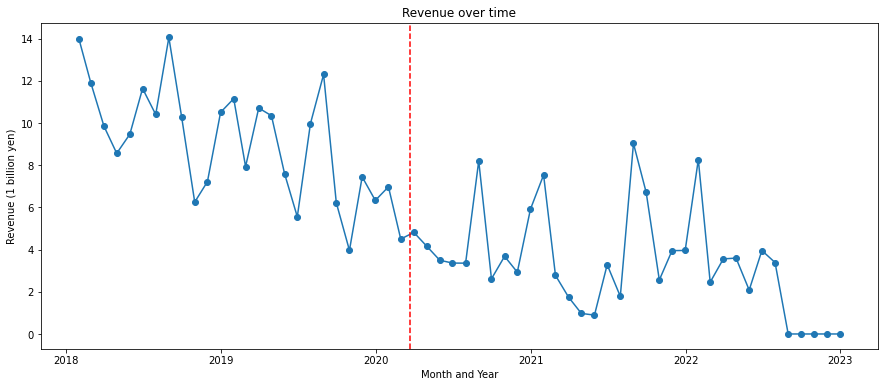

In [39]:
plt.figure(figsize=(15,6))
plt.plot_date(monthly_revenue_df.Month, monthly_revenue_df.Revenue, linestyle='solid')
plt.axvline(dt.datetime(2020, 3, 21), color="red", linestyle="dashed")
plt.title("Revenue over time")
plt.xlabel("Month and Year")
plt.ylabel("Revenue (1 billion yen)")
plt.show()

Text(0, 0.5, 'Revenue (billion yen)')

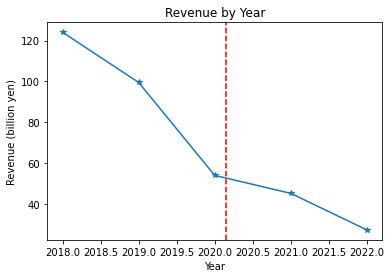

In [79]:
yearly_revenue = pd.DataFrame(list(zip(sorted(set(monthly_revenue_df.dropna()['Month'].dt.year)), list(monthly_revenue_df.groupby(monthly_revenue_df.dropna().Month.dt.year).sum()['Revenue']))), 
             columns = ['Year', 'Revenue'])
plt.plot(yearly_revenue.Year, yearly_revenue.Revenue, marker="*")
plt.axvline(2020.15, color="red", linestyle="dashed")
plt.title("Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Revenue (billion yen)")

In [83]:
price_series = pd.Series(yearly_revenue.Revenue)
price_series.pct_change()

0         NaN
1   -0.198103
2   -0.457309
3   -0.163146
4   -0.395942
Name: Revenue, dtype: float64

Based on the plot, there has been a general trend of decreasing revenue. The red line indicates the general date of the Covid-19 pandemic (denoted as March 21st, 2020.) However, there are still several spikes.
There is a sharp decline in revenue from 2019 to 2020 with a 45.73% decrease in revenue, which could be due to the pandemic.
The second greatest decrease in revenue (by percent) is from 2020 to 2021 with a 39.59% decrease in revenue. 

<Figure size 648x432 with 0 Axes>

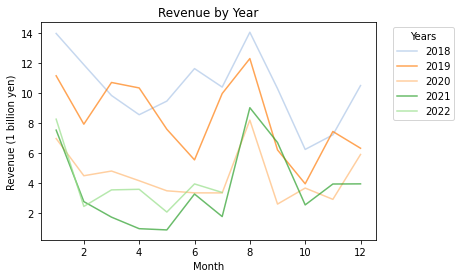

In [41]:
plt.figure(figsize=(9,6))
fig, ax = plt.subplots()

years = set(monthly_revenue_df.dropna().Month.dt.year)
palette = plt.get_cmap('tab20')
num=0
for year in years:
    num+=1
    temp_df = monthly_revenue_df[monthly_revenue_df.Month.dt.year == year].dropna()
    plt.plot(temp_df.Month.dt.month, temp_df.Revenue, color=palette(num), alpha=0.7, label=year)

# Add legend
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1),title="Years")

plt.title("Revenue by Year")
plt.xlabel("Month")
plt.ylabel("Revenue (1 billion yen)")
plt.show()

This is another plot of the revenue by year, and we can definitely see that the the revenue has generally decreased throughout the years. 2018 appears to be FGO's best year in terms of revenue. Currently, FGO has earned more in 2022 than in 2021 comparatively to the months where data is available, but I believe the hallmark of the trend will be the spike in August (month 8) because of the game's anniversary banner.
There appears to be a drop in July, the month before the game's anniversary. This is traditionally seen as a dead month where the game prepares to release new content for anniversary. 
It's apparent that there is a spike in January and in August, but let's see how much revenue the game earns each month.

<Figure size 648x432 with 0 Axes>

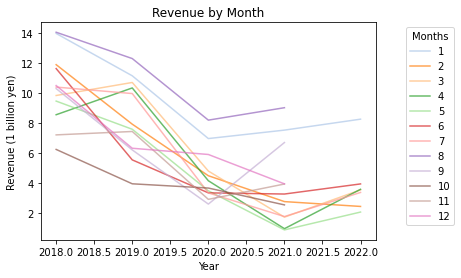

In [42]:
plt.figure(figsize=(9,6))
fig, ax = plt.subplots()

months = set(monthly_revenue_df.dropna().Month.dt.month)
palette = plt.get_cmap('tab20')
num=0
for month in months:
    num+=1
    temp_df = monthly_revenue_df[monthly_revenue_df.Month.dt.month == month].dropna()
    plt.plot(temp_df.Month.dt.year, temp_df.Revenue, color=palette(num), alpha=0.7, label=month)

# Add legend
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1),title="Months")

plt.title("Revenue by Month")
plt.xlabel("Year")
plt.ylabel("Revenue (1 billion yen)")
plt.show()

Based on this plot, we can confirm that FGO generates the most revenue in August and January. This is most likely because of the game's Guaranteed SSR banner during these times (New Year's and Anniversary). This banner requires one to purchase in-game (paid saint quartz) and guarantees the player one of the featured limited high-rarity units in the banner in a single 10-pull roll (unlike other banners which only gurantee the featured limited high-rarity unit in 330 rolls.)
We can check which months have Guaranteed SSR banners.

In [43]:
gssr_months = list(set(df3[[bool(re.search("Guaranteed", i)) for i in df3.Name]]['JP Start Date'].dt.month))
gssr_months = [x for x in gssr_months if math.isnan(x) == False]
for i in range(0,len(gssr_months)):
    gssr_months[i] = calendar.month_name[int(gssr_months[i])]

print(gssr_months)

['January', 'July', 'August']


January, August, and July have Guaranteed SSR banners. We can check which banners these are.

In [44]:
df3[[bool(re.search("Guaranteed", i)) for i in df3.Name]][['Name', 'JP Start Date', 'JP End Date']].drop_duplicates()

,Name,JP Start Date,JP End Date
11,Thanksgiving Guaranteed Summon,NaT,NaT
58,2019 New Years' Guaranteed Gacha,NaT,NaT
85,FGO 2019 2nd Anniversary Guaranteed Gacha,NaT,NaT
110,New Year's Celebration 2020 Guaranteed Summon ...,2018-01-01,2018-01-19
145,Fate/Grand Order 3nd Anniversary Guaranteed Su...,2018-07-29,2018-08-12
167,New Year's 2021 Guaranteed Summon,2019-01-01,2019-01-10
206,FGO 2021 ~4th Anniversary~ Guaranteed Summon,2019-08-04,2019-08-18
233,Happy New Year 2022 Guaranteed Lucky Bag Summo...,2020-01-01,2020-01-10
267,5th Anniversary Guaranteed Lucky Bag Summon (D...,2020-08-10,2020-08-24
290,[JP] New Year 2023 Red White x Knight-Cavalry-...,2021-01-01,2021-01-10


We see there's only one GSSR banner that starts in July, and it mostly spans through August. This probably does not affect the monthly revenue ranking too much even though most people tend to spend money on the first day of the banner because of its novelty.

## Number of New Servants and Revenue

We can examine the relationship between the number of new servants and revenue by year and by banner (indicated by release date).

Below is the aggregated table of the number of new servants by release date. 

In [45]:
num_new_servants = pd.DataFrame(list(zip(sorted(list(set(test['Release']))), test.groupby(['Release']).count()['Name'])), 
             columns = ['Release Date', 'Num New Servants'])[2:]
num_new_servants.head()

,Release Date,Num New Servants
2,2015-07-25,1
3,2015-08-17,1
4,2015-09-06,5
5,2015-09-28,2
6,2015-10-11,2


Below is the plot of the number of new servants over time. I excluded unreleased servants and units released at release.

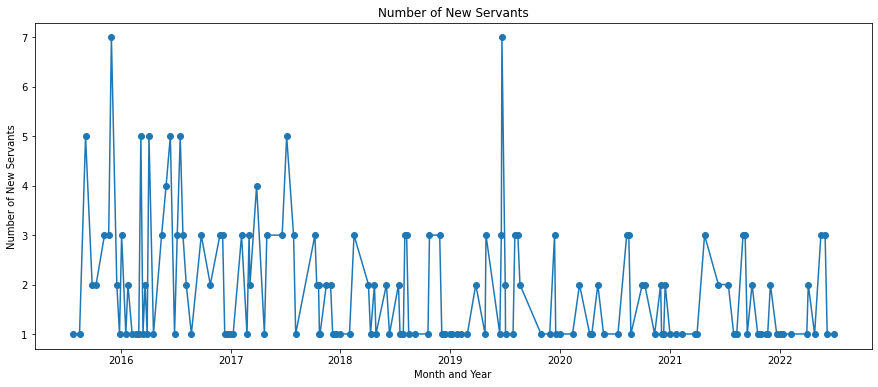

In [46]:
plt.figure(figsize=(15,6))
plt.plot_date(num_new_servants['Release Date'], num_new_servants['Num New Servants'], linestyle="solid")
plt.title("Number of New Servants")
plt.xlabel("Month and Year")
plt.ylabel("Number of New Servants")
plt.show()

There is a spike during January 2016 and mid-2019. While I don't know the reasoning for the number of new servants in early 2016, the reason for the spike in mid-2019 has to do with the Friend Points servants campaign where the game released 7 new friend points servants. Players use friend points instead of saint quartz to roll on this banner thus making it completely irrelevant to revenue. Other than these spikes, there are generally around 1-3 new servants released per banner.

Below is the plot of the number of new servant and revenue by time.

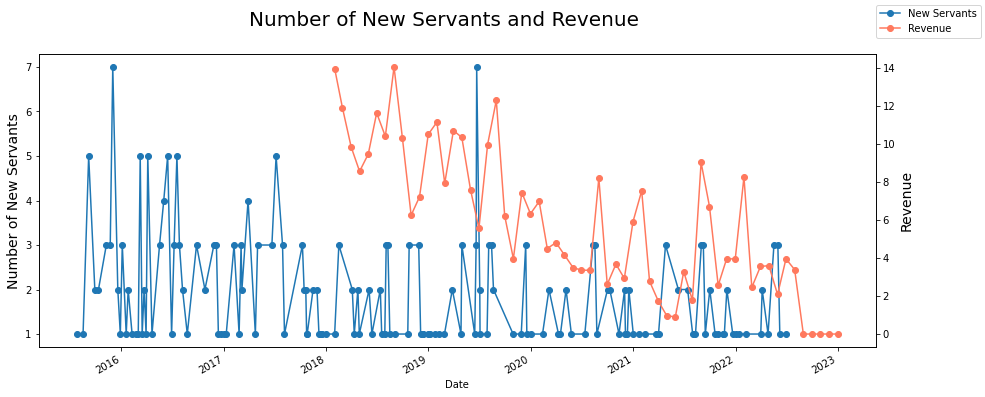

In [47]:
colrev= "#ff795e"
fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot_date(num_new_servants['Release Date'], num_new_servants['Num New Servants'], linestyle="solid")
ax2.plot_date(monthly_revenue_df.Month, monthly_revenue_df.Revenue, color=colrev, linestyle='solid')

ax1.set_xlabel("Date")
ax1.set_ylabel("Number of New Servants", fontsize=14)
ax1.tick_params(axis="y")

ax2.set_ylabel("Revenue", fontsize=14)
ax2.tick_params(axis="y")
fig.legend(['New Servants', 'Revenue'])

fig.suptitle("Number of New Servants and Revenue", fontsize=20)
fig.autofmt_xdate()

Revenue seems to generally follow the same trends as the number of new servants. July 2019 is an exception, but I previously mentioned the reason for it.

### Num new servants by year

We can look at the number of new units released each year.

In [48]:
new_servants_year = pd.DataFrame(list(zip(sorted(set(test.dropna()['Release'].dt.year)), test.groupby(test.dropna()['Release'].dt.year).count()['Name'])), 
             columns = ['Release Year', 'Num New Servants'])
new_servants_year

,Release Year,Num New Servants
0,2015,82
1,2016,65
2,2017,46
3,2018,36
4,2019,40
5,2020,27
6,2021,31
7,2022,16


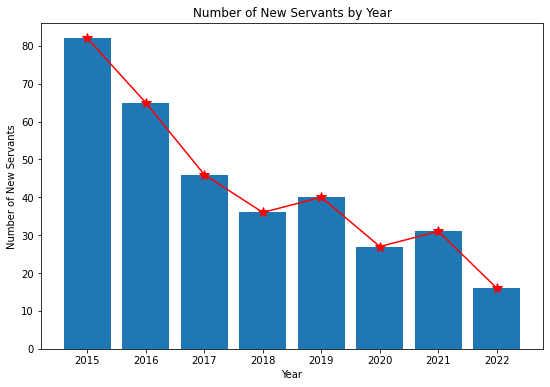

In [49]:
plt.figure(figsize=(9,6))
plt.bar(new_servants_year['Release Year'], new_servants_year['Num New Servants'])
plt.plot(new_servants_year['Release Year'], new_servants_year['Num New Servants'], marker="*", color='red', ms=10)
plt.title("Number of New Servants by Year")
plt.xlabel("Year")
plt.ylabel("Number of New Servants")
plt.show()

Based on the plot, 2020 had the lowest number of new servants (excluding 2022 because it is still 2022.) 2018 is the second lowest in terms of new servants released, but it also had the highest revenue among the years that we have revenue data.
2021 released more servants than 2020 but still experience a decrease in revenue.

### Number of New Servants and Revenue

<AxesSubplot:xlabel='Num New Servants', ylabel='Revenue'>

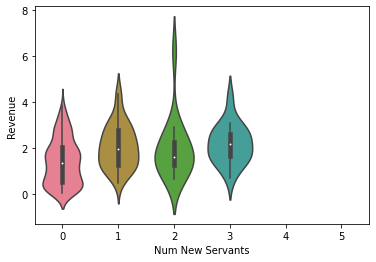

In [50]:
sns.violinplot(x='Num New Servants', y = 'Revenue', data=df3, palette = 'husl')

Each banner has at most up to 5 new servants, but we only have revenue information for banners with up to 3 new servants. Since there are multiple banners with 0, 1, 2, or 3 new servants, we can treat the number of new servants as a category.
Based on our violin plots, it appears that banners with 1 or 3 new servants have the highest average revenue. Banners with 2 new servants have a wider variance than banners with more or less new servants. Banners wtih 0 new servants appear to have the lowest average revenue.
This seems logical because players want new content, not old content. However, if a good unit appears again, they might feel an incentive to spend. Majority of the units most likely do not incentivize players to spend, especially if they spent money on the unit's debut banner and obtained the unit.

In [51]:
pearsonr(df3.dropna().drop_duplicates()['Num New Servants'], df3.dropna().drop_duplicates().Revenue)

(0.24773807917656254, 0.0032779660350773046)

The Pearson correlation between revenue and the number of new servants per banner is 0.2477. The two-tailed p-value =  0.003277 is statistically significant suggesting that there is a correlation between revenue and the number of new servants.
This makes sense since the novelty of new characters attracts players, hence they spend more money to obtain said character.

## Other crosstabs and interesting interactions

### Release Year and Status

In [52]:
pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Status'])

Status,Friend Point Summon Only,Limited,Non-Limited,Starting Servant,Story-locked,Welfare
Release,,,,,,
2015,0,4,66,2,6,4
2016,1,23,22,0,12,7
2017,0,18,16,0,5,7
2018,0,15,12,0,4,5
2019,7,20,6,0,3,4
2020,0,18,5,0,1,3
2021,1,17,5,0,2,6
2022,0,9,4,0,2,1


<AxesSubplot:xlabel='Release'>

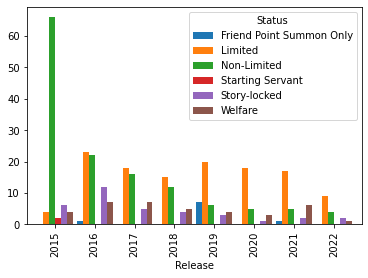

In [53]:
pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Status']).plot.bar(width=0.9)

2015, the game's release year, released the most new servants.
Excluding 2022, which has not concluded yet, there does not seem to be a notable difference in the number of new limited-time servants released. This is interesting because one would think players spend more money to obtain Limited-time servants, meaning that more limited-time servants would result in higher revenue. This doesn't seem to be the case.

In [54]:
pearsonr(yearly_revenue.Revenue, list(pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Status'])["Limited"])[3:])

(0.4514730011679082, 0.4453399570010059)

The Pearson correlation between Revenue and the number of Limited servants that are obtainable per year is 0.4521 and the two-tailed p-value is 0.4458, which is not statistically significant.

### Release Year and Gender

In [55]:
year_gender = pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Gender'])
year_gender['Female/Male Difference'] = list(np.subtract(np.array(year_gender.Female), np.array(year_gender.Male)))
year_gender

Gender,Female,Male,Unknown,Female/Male Difference
Release,,,,
2015,36,45,1,-9
2016,38,26,1,12
2017,33,12,1,21
2018,21,14,1,7
2019,26,12,2,14
2020,16,7,4,9
2021,21,5,5,16
2022,8,8,0,0


<AxesSubplot:xlabel='Release'>

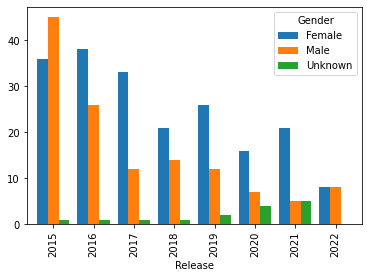

In [56]:
pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Gender']).plot.bar(width= .8)

As always, we should exclude 2022 from our overall observations because it isn't over yet. Based on the plot, every year except 2015 have released more female characters than male charaters. 2018 has the smallest difference between the number of female servants released compared to the number of male servants released. Meanwhile, out of the years that we have revenue data for, 2021 has the greatest difference.
FGO also saw the highest revenue in 2018 and its lowest revenue in 2021. Is this is a coincidence? Let's measure it.

In [57]:
#Revenue and number of female characters released correlation
pearsonr(yearly_revenue.Revenue, list(pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Gender'])["Female"])[3:])

(0.7140218019070603, 0.17549504934643154)

In [58]:
#Revenue and number of male characters released correlation
pearsonr(yearly_revenue.Revenue, list(pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Gender'])["Male"])[3:])

(0.893470222906436, 0.041065397533987316)

In [59]:
#Revenue and difference between the number of female characters released and male characters released correlation
pearsonr(yearly_revenue.Revenue, year_gender['Female/Male Difference'][3:])

(0.2462309400521943, 0.6896864956438421)

The Pearson correlation between yearly revenue and the number of new female servants released by year is 0.7145 with a two-tailed p-value of 0.1751.
The Pearson correlation between yearly revenue and the number of new male servants released by year is 0.8931 with a two-tailed p-value of 0.0412. 
The Pearson correlation between yearly revenue and the difference between the number of new female servants and new male servants released by year is 0.2469 with a two-tailed p-value of 0.6888. 
The p-value for the correlation between yearly revenue and the number of new male servants is significant at $\alpha$ = 0.05. However, the p-value for revenue and the difference between the number of new female servants and new male servants is not significant.
The significant p-value from the second test is probably related to the lower number of new servants as a whole rather than  the lower number of a specific type of servant.

### Revenue and Rarity

In [60]:
#Revenue and the correlation between the difference of the number of female servants - number of male servants
pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Rarity'])

Rarity,1,2,3,4,5
Release,,,,,
2015,6,11,24,24,17
2016,1,0,10,28,26
2017,1,0,3,28,14
2018,0,0,4,17,15
2019,3,4,4,13,16
2020,1,0,0,11,15
2021,0,0,0,16,15
2022,0,0,1,6,9


<AxesSubplot:xlabel='Rarity'>

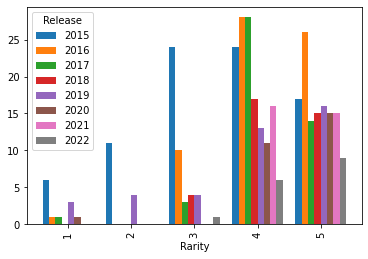

In [61]:
pd.crosstab(test.dropna()['Rarity'], test.dropna()['Release'].dt.year).plot.bar(width=0.8)

Based on our plot, most of the low-rarity servants (1-3) were released in earlier years. 2016 released the most 5-star servants. 2016 and 2017 released the most 4-star servants. 
FGO has released a relatively constant number of new 5-star servants between 2017 and 2021. 
There doesn't seem to be an indication that 4-star servants or 5-star servants increase revenue, so lets' quantify it.

In [75]:
rarity_release = pd.crosstab(test.dropna()['Release'].dt.year, test.dropna()['Rarity']).iloc[3:, 3:5]
rarity_release['High Rarity'] = list(np.add(np.array(rarity_release.iloc[:, 0:1]), np.array(rarity_release.iloc[:, 1:])).flatten())
rarity_release

Rarity,4,5,High Rarity
Release,,,
2018,17,15,32
2019,13,16,29
2020,11,15,26
2021,16,15,31
2022,6,9,15


In [63]:
pearsonr(yearly_revenue.Revenue, rarity_release.iloc[:, 0:1])

(array([0.6680009056125311], dtype=object), 0.21783683722163075)

In [64]:
pearsonr(yearly_revenue.Revenue, rarity_release.iloc[:, 1:])

(array([0.6270946004353035], dtype=object), 0.2575175683781359)

In [77]:
pearsonr(yearly_revenue.Revenue, rarity_release['High Rarity'])

(0.6846001581203182, 0.2022689868673354)

The Pearson correlation between yearly revenue and the number of 4-star servants released yearly is 0.6680 with a two-sided p-value 0.2178.
The Pearson correlation between yearly revenue and the number of 5-star servants released yearly is 0.6271 with a two-sided p-value 0.2575.
The Pearson correlation between yearly revenue and the number of high-rarity servants released yearly is 0.0.6846 with a two-sided p-value 0.2024.
None of these p-values are statistically significant, just as we suspected.

# Conclusion and Future Work

## Conlusion

## Future Work

We could analyze player statistics. What characters do players want the most? How much do people spend on average? What does the demographic of the player-base look like? Does this have a correlation to the revenue?
FGO's 2021 survery results can be found <a href="https://www.google.com/search?q=fgo+survery+2021&rlz=1C1VDKB_enUS943US943&oq=fgo+survery+2021&aqs=chrome..69i57j0i22i30l6j0i390.2231j0j4&sourceid=chrome&ie=UTF-8">here</a>.

We can also analyze other app statistics. How many active users are there throughout the years? How are the game's ratings? Do they follow the same trend as the game's revenue trends? App statistics can be found on <a href="https://sensortower.com/">SensorTower</a> or <a href="https://www.data.ai/en/">Data.ai</a>.

How have real world events affected the game? Did Covid-19 affect the game revenue? Though it seems like it may have affected the revenue, we can try to quantify it.

In late December, 2021, Fate/Grand Order's developers, Delightworks, changed names to Lasengle. The companies shared were acquired by Aniplex February 2022. Will this acquisition in stocks and possibly affect the revenue?